In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [3]:
DATASET_PATH = '../datasets/data/ddos_benign.csv'
MODEL_PATH = '../models/model.pth'
EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.001
RANDOM_STATE = 13052003

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
data = pd.read_csv(DATASET_PATH, delimiter=',')

In [6]:
# Удаляем лишние пробелы в label
data.columns = data.columns.str.strip()
data = data.fillna(0).replace([np.inf, -np.inf], 0)

In [7]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [8]:
data.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [9]:
data['Label'].unique()

array(['BENIGN', 'DDoS'], dtype=object)

In [10]:
# BENIGN = 0, DDoS = 1
le = LabelEncoder()
data['Label'] = le.fit_transform(data['Label'])

In [11]:
X = data.drop('Label', axis="columns")
y = data['Label']

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [13]:
print(X.shape, y.shape)

(225745, 78) (225745,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [15]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(180596, 78) (45149, 78)
(180596,) (45149,)


In [16]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [17]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [18]:
class DDoSDetector(nn.Module):
    def __init__(self, input_size):
        super(DDoSDetector, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.model(x)

In [19]:
model = DDoSDetector(input_size=X_train.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [20]:
train_losses = []
train_accuracies = []
test_accuracies = []

In [21]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    train_acc = 100 * correct / total
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    # Тестовая точность после каждой эпохи
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            test_total += y_batch.size(0)
            test_correct += (predicted == y_batch).sum().item()
    test_acc = 100 * test_correct / test_total
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

Epoch 1/10, Loss: 0.0194, Train Acc: 99.54%, Test Acc: 99.90%
Epoch 2/10, Loss: 0.0042, Train Acc: 99.90%, Test Acc: 99.90%
Epoch 3/10, Loss: 0.0034, Train Acc: 99.91%, Test Acc: 99.91%
Epoch 4/10, Loss: 0.0033, Train Acc: 99.91%, Test Acc: 99.91%
Epoch 5/10, Loss: 0.0030, Train Acc: 99.91%, Test Acc: 99.92%
Epoch 6/10, Loss: 0.0026, Train Acc: 99.92%, Test Acc: 99.92%
Epoch 7/10, Loss: 0.0029, Train Acc: 99.92%, Test Acc: 99.90%
Epoch 8/10, Loss: 0.0025, Train Acc: 99.93%, Test Acc: 99.94%
Epoch 9/10, Loss: 0.0023, Train Acc: 99.94%, Test Acc: 99.93%
Epoch 10/10, Loss: 0.0023, Train Acc: 99.94%, Test Acc: 99.91%


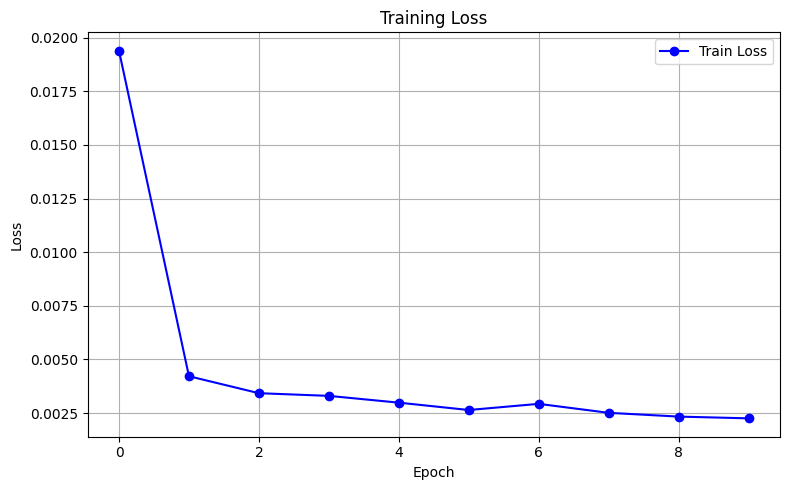

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', color='blue', marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

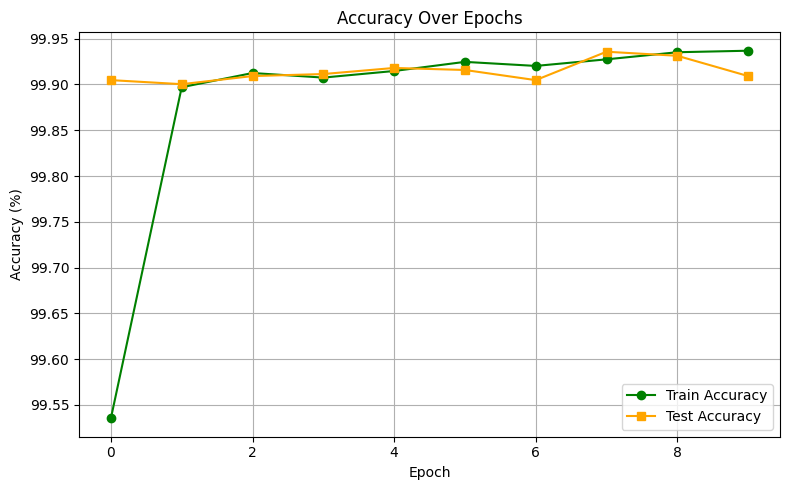

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Train Accuracy', color='green', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', color='orange', marker='s')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        test_total += y_batch.size(0)
        test_correct += (predicted == y_batch).sum().item()

print(f"\nTest Accuracy: {100 * test_correct / test_total:.2f}%")


Test Accuracy: 99.91%


In [50]:
torch.save(model.state_dict(), MODEL_PATH)
print(f"Модель сохранена в файл: {MODEL_PATH}")

Модель сохранена в файл: ../models/model.pth


In [42]:
# data = pd.read_csv('../datasets/traffic_dataset.csv', delimiter=',', nrows=1000)
data = pd.read_csv('../features/features.csv', delimiter=',')
print(f'Number of Rows: {data.shape[0]}')
print(f'Number of Columns: {data.shape[1]}')

Number of Rows: 40
Number of Columns: 78


In [43]:
# data["LabelName"].unique()

In [44]:
features = ['Destination Port', 'Flow Duration', 'Total Fwd Packets',
    'Total Backward Packets', 'Total Length of Fwd Packets',
    'Total Length of Bwd Packets', 'Fwd Packet Length Max',
    'Fwd Packet Length Min', 'Fwd Packet Length Mean',
    'Fwd Packet Length Std', 'Bwd Packet Length Max',
    'Bwd Packet Length Min', 'Bwd Packet Length Mean',
    'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
    'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
    'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
    'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
    'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
    'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
    'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
    'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
    'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
    'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
    'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio',
    'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
    'Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk',
    'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk',
    'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', 'Subflow Fwd Bytes',
    'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward',
    'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward',
    'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean',
    'Idle Std', 'Idle Max', 'Idle Min']

if 'Label' in data.columns:
    features.append('Label')


In [45]:
data["Label"]

KeyError: 'Label'

In [38]:
data.columns = data.columns.str.replace('.', ' ', regex=False)
data.columns = data.columns.str.replace('/', ' / ')
data.columns = data.columns.str.strip()

In [39]:
selected_features = [f for f in features if f in data.columns]
data_filtered = data[selected_features]
print(data_filtered.head())

   Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0             59562      67.490968               1594                       0   
1               443      54.210707                  0                      24   
2             53776      60.415314                 10                       0   
3                53      56.051169                  0                       6   
4               443      56.107188                  0                      16   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                       343700                            0   
1                            0                         3883   
2                          540                            0   
3                            0                          544   
4                            0                         1450   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                   1354                     54            

In [40]:
data_filtered = data_filtered.copy()

original_features = list(scaler.feature_names_in_)
for col in original_features:
    if col not in data_filtered.columns:
        data_filtered[col] = 0.0

data_filtered = data_filtered[[*original_features, 'Label']]

X_new = data_filtered.drop('Label', axis=1)
y_new = data_filtered['Label']

X_new = scaler.transform(X_new)
X_new_tensor = torch.tensor(X_new, dtype=torch.float32).to(device)
y_new_tensor = torch.tensor(LabelEncoder().fit_transform(y_new), dtype=torch.long).to(device)

model.eval()
with torch.no_grad():
    outputs = model(X_new_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_new_tensor).sum().item() / y_new_tensor.size(0) * 100
    print(f"Test Accuracy on New Dataset: {accuracy:.2f}%")


KeyError: "['Label'] not in index"

In [41]:
X_new = data_filtered.drop('Label', axis=1)
y_new = data_filtered['Label']

X_new = scaler.transform(X_new)
X_new_tensor = torch.tensor(X_new, dtype=torch.float32).to(device)
y_new_tensor = torch.tensor(LabelEncoder().fit_transform(y_new), dtype=torch.long).to(device)

model.eval()
with torch.no_grad():
    outputs = model(X_new_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_new_tensor).sum().item() / y_new_tensor.size(0) * 100
    print(f"Test Accuracy on New Dataset: {accuracy:.2f}%")


KeyError: "['Label'] not found in axis"